In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import sqrt
from model import Model
from rbm import RBM
from operator import Operator

# Simple attempt to implement a variational quantum state calculation 

As an example, we start with a very simple J1/J2 Heisenberg spin chain

We define a class "model" that contains a Hamiltonian and a rule for generating spins according to the MSMS algorithm.

We have something to obtain the wavefunction amplitude $\psi_\theta(s)$ from the spin configuration $s$ that depends on some amplitude $\theta$

From  $\psi_\theta(s)$ for the given spin configuration, we can produce an estimate of the energy of the variational ground state.

Then we can perform a stochastic gradient descent based on it.

Reminder: the operators are defined as 
$$S\cdot S = S_x \cdot S_x + S_y \cdot S_y + S_z \cdot S_z = \frac{1}{2} (S_+ \cdot S_- + S_- \cdot S_+) + S_z \cdot S_z$$

where $S_z = \frac{\hbar}{2} \begin{pmatrix} 1 & 0 \\ 0  & -1 \end{pmatrix}$, $S_+ = \hbar \begin{pmatrix} 0 & 1 \\ 0 & 0 \end{pmatrix} = S_x + S_y$, $S_- = \hbar \begin{pmatrix} 0 & 0 \\ 1 & 0 \end{pmatrix} = S_x - S_y$. A singlet state has energy $-3J/4$ and a triplet state has energy $J/4$

## Miscellaneous sanity checks

The sanity check has been migrated to operator.py

### Verifying that the Hamiltonian evaluated onto spins give sensible results

### Generating random spins

In [ ]:
test = Model(4, 4)
test.get_random_spins()

array([[[1, 0],
        [0, 1],
        [1, 0],
        [1, 0]],

       [[0, 1],
        [1, 0],
        [1, 0],
        [1, 0]],

       [[1, 0],
        [0, 1],
        [0, 1],
        [1, 0]],

       [[1, 0],
        [1, 0],
        [1, 0],
        [0, 1]]])

### Plotting out the adjacency elements of the J1 hamiltonian

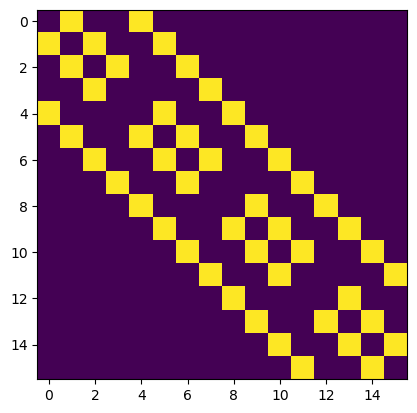

In [28]:
test = Model(4, 4)
test.reset_Hamiltonian()
test.set_J1_Hamiltonian(1)
np.linalg.norm(test.Hamiltonian)
plt.imshow(np.sum(test.get_Hamiltonian.reshape(16, 16, 16), axis = -1))

# Implementation of the RBM class

After having a class of spin and Hamiltonian, consider a wavefunction object, take takes a spin and returns a number. The variational quantum state is defined as 

\begin{align*}
\Psi_M(S;W) = \sum_{h_i} e^{\sum_j a_j \sigma^z_j + \sum_i b_i h_i + \sum_{ij} W_{ij} h_i \sigma^{z}_j}
\end{align*}

Here the free parameters of the models are $a_i, b_, W_{ij}$ and $h_1, \dots, h_M$ represents auxilliary spin variables in the network. The internal spins can be explicited traced out to read

\begin{align*}
\Psi(S;W) = e^{\sum_j a_j \sigma^z_j} \times \Pi_{i=1}^M F_i(S)
\end{align*}

where

\begin{align*}
F_i(S) = 2\cosh\left[ b_i + \sum_J W_{ij} \sigma^z_j\right] =  2\cosh\theta_i
\end{align*}

The object would be an NN (most basic example includes the Carleo RBM, which actually has an analytical form) 

I need a function to compute the variational energy. A function to give gradient. And a function to do the gradient descent.


In [311]:
class RBM:
    """
    A reduced Boltzmann machine that implements the spin wavefunction based on the model class
    """
    def __init__(self, model) -> None:
        self.model = model
        self.L1 = model.L1
        self.L2 = model.L2
        self.M = 3*int(self.L1*self.L2/2)

        self.a = np.random.random(self.L1*self.L2)-0.5#np.ones(self.L1 * self.L2)
        self.b = np.random.random(self.M)-0.5#np.zeros(self.M)
        self.M = np.random.random((self.M, self.L1 * self.L2))-0.5#np.ones((self.M, self.L1 * self.L2))

    def theta(self, spin)->float:
        """
        Helper function: evaluates the product bj + Wij sigma i
        """
        assert spin.shape == (self.L1, self.L2, 2), f"Invalid spin shape {spin.shape}"
        projected_spin = self.model.project_spin(spin)
        return self.b + np.dot(self.M, projected_spin)

    def evaluate(self, spin) -> float:
        """
        Evaluate the wavefunction for a given spin configuration
        """
        assert spin.shape == (self.L1, self.L2, 2), f"Invalid spin shape {spin.shape}"
        projected_spin = self.model.project_spin(spin)
        #print(self.M, projected_spin, np.prod(2 * np.cosh(self.b + np.dot(self.M, projected_spin))))
        return np.exp(np.dot(self.a, projected_spin)) * np.prod(2 * np.cosh(self.b + np.dot(self.M, projected_spin)))

    def evaluate_dummy(self, spin) -> float:
        assert spin.shape == (self.L1, self.L2, 2), f"Invalid spin shape {spin.shape}"
        return 20 if (spin[0, 0, 0] == 1 and spin[0,1,0] == 1) else 1

    def metropolis_step(self, spin):
        """
        Perform a single Metropolis step
        """
        spin2 = self.model.flip_random_spin(spin)
        #print(self.evaluate(spin2),self.evaluate(spin))
        #p = min(1, (self.evaluate(spin2) / self.evaluate(spin))**2)
        p = min(1, (self.evaluate_dummy(spin2) / self.evaluate_dummy(spin)))
        if random.random() < p:
            return spin2
        return spin
    
    def create_batch(self, N, burn_in = 100, skip = 10):
        """
        Create a batch of N spins
        """
        assert type(N) == int and N >= 1
        result_array = np.zeros((N, self.L1, self.L2, 2), dtype = int)
        current_spins = self.model.get_random_spins()
        for _ in range(burn_in):
            current_spins = self.metropolis_step(current_spins)
        #print(result_array.shape, current_spins.shape, self.L1, self.L2)
        result_array[0] = current_spins
        for i in range(1, N*skip):
            current_spins = self.metropolis_step(current_spins)
            if i % skip == 0:
                result_array[i//skip] = current_spins
        return result_array

    def expectation_value(self, operator, spin, burn_in = 100, skip = 10):
        """
        Evaluate the expectation value of an operator for a given spin configuration
        """
        assert spin.shape == (self.L1, self.L2, 2), f"Invalid spin shape {spin.shape}"
        spin1 = spin
        spin2s = self.model.generate_local_spins(spin1, change = 2)#[self.model.get_random_spins() for _ in range(N)]#self.create_batch(N, burn_in = burn_in, skip = skip)
        result = 0
        for spin2 in spin2s:
            #print(spin1, spin2)
            #print(spin1, spin2, operator.vdot(spin1, spin2), self.evaluate_dummy(spin2), self.evaluate_dummy(spin1))
            result += operator.vdot(spin1, spin2) * self.evaluate_dummy(spin2) / self.evaluate_dummy(spin1)
        return result

# Operators and derivatives: 

Noting that an operator dcdan be approximated by its local value

\begin{align*}
O_{loc}(s) = \sum_{s, s'}  \left< s\middle| O \middle| s' \right>\frac{\left<s' \middle| \Phi_\theta\right>}{\left<s \middle| \Phi_\theta\right>}
\end{align*}

and an operator's expectation value can be reasonably approximated by 

\begin{align*}
\left<O \right> = \sum_{s} P(s) O_{loc}(s) \approx \frac{1}{M} \sum_{s_i} O_{loc}(s_i)
\end{align*}

Now consider the energy minimization. Let $O_p(s) = \frac{\partial}{\partial \theta_p} \log \left<s\middle|\Psi_\theta\right> = \left<s\middle|O_p \middle| s\right> $,

\begin{align*}
\frac{\partial E(\theta)}{\partial \theta_p} &= 2 \Re \left[ \left\langle E_{\text{loc}}(\mathbf{s}) O^*(\mathbf{s}) \right\rangle - \left\langle E_{\text{loc}}(\mathbf{s}) \right\rangle \left\langle O^*(\mathbf{s}) \right\rangle \right] \\
&= 2 \Re \left[ \left\langle (E_{\text{loc}}(\mathbf{s}) - \left\langle E_{\text{loc}}(\mathbf{s}) \right\rangle) O^*(\mathbf{s}) \right\rangle \right]
\end{align*}


## Sanity check: expectation value of operators 

### Two-site operators (SzSz only, for now)

In [316]:
model = Model(2,2)
rbm = RBM(model)
average_expectations = [rbm.expectation_value(SzSz_(0,0,0,1,model), np.array([[[1, 0], [0, 1]], [[0, 1], [1, 0]]])) for _ in range(40)]
print(f"The average expectation <SzSz|ud__|SzSz> is {np.mean(average_expectations)} with standard deviation {np.std(average_expectations)}")
average_expectations = [rbm.expectation_value(SzSz_(0,0,0,1,model), np.array([[[0, 1], [0, 1]], [[0, 1], [1, 0]]])) for _ in range(40)]
print(f"The average expectation  <Sz|dd__|Sz> is {np.mean(average_expectations)} with standard deviation {np.std(average_expectations)}")
rbm = RBM(model)
batch = rbm.create_batch(200) #This uses evaluate_dummy, which gives 2/3 for spin up and 1/3 for spin down 
average_expectations = [rbm.expectation_value(SzSz_(0,0,0,1,model), batch[i]) for i in range(len(batch))]
print(f"The average expectation for a 2:1 mixed state is {np.mean(average_expectations)})")

The average expectation <SzSz|ud__|SzSz> is (-0.25+0j) with standard deviation 0.0
The average expectation  <Sz|dd__|Sz> is (0.25+0j) with standard deviation 0.0
The average expectation for a 2:1 mixed state is (0.20500000000000002+0j))


### One-site operator (Sz makes sense. Unsure if Sx does, but I'll sweep it under the rug for now.)

In [253]:
model = Model(2,2)
rbm = RBM(model)
average_expectations = [rbm.expectation_value(Sz_(0,0,model), np.array([[[1, 0], [0, 1]], [[0, 1], [1, 0]]])) for _ in range(40)]
print(f"The average expectation <Sz|u___|Sz> is {np.mean(average_expectations)} with standard deviation {np.std(average_expectations)}")
average_expectations = [rbm.expectation_value(Sz_(0,0,model), np.array([[[0, 1], [1, 0]], [[0, 1], [1, 0]]])) for _ in range(40)]
print(f"The average expectation  <Sz|d___|Sz> is {np.mean(average_expectations)} with standard deviation {np.std(average_expectations)}")
rbm = RBM(model)
batch = rbm.create_batch(200) #This uses evaluate_dummy, which gives 2/3 for spin up and 1/3 for spin down 
average_expectations = [rbm.expectation_value(Sz_(0,0,model), batch[i]) for i in range(len(batch))]
print(f"The average expectation for a 2:1 mixed state is {np.mean(average_expectations)})")

The average expectation <Sz|u___|Sz> is (0.5+0j) with standard deviation 0.0
The average expectation  <Sz|d___|Sz> is (-0.5+0j) with standard deviation 0.0
The average expectation for a 2:1 mixed state is 0j)


In [254]:
model = Model(2,2)
rbm = RBM(model)
average_expectations = [rbm.expectation_value(Sz_(1,0,model)+Sz_(0,1,model), np.array([[[1, 0], [0, 1]], [[0, 1], [1, 0]]])) for _ in range(40)]
print(f"The average expectation <Sz|u___|Sz> is {np.mean(average_expectations)} with standard deviation {np.std(average_expectations)}")
average_expectations = [rbm.expectation_value(Sz_(1,0,model)+Sz_(0,1,model), np.array([[[0, 1], [1, 0]], [[0, 1], [1, 0]]])) for _ in range(40)]
print(f"The average expectation  <Sz|d___|Sz> is {np.mean(average_expectations)} with standard deviation {np.std(average_expectations)}")
rbm = RBM(model)
batch = rbm.create_batch(200) #This uses evaluate_dummy, which gives 2/3 for spin up and 1/3 for spin down 
average_expectations = [rbm.expectation_value(Sz_(1,0,model)+Sz_(0,1,model), batch[i]) for i in range(len(batch))]
print(f"The average expectation for a 2:1 mixed state is {np.mean(average_expectations)})")

The average expectation <Sz|u___|Sz> is (-1+0j) with standard deviation 0.0
The average expectation  <Sz|d___|Sz> is 0j with standard deviation 0.0
The average expectation for a 2:1 mixed state is (0.02+0j))


In [256]:
operator = Operator(model)
for i in range(2):
    for j in range(2):
        operator += Sz_(i, j, model)
model = Model(2,2)
rbm = RBM(model)
average_expectations = [rbm.expectation_value(operator, np.array([[[1, 0], [0, 1]], [[0, 1], [1, 0]]])) for _ in range(40)]
print(f"The average expectation <Sz|u___|Sz> is {np.mean(average_expectations)} with standard deviation {np.std(average_expectations)}")
average_expectations = [rbm.expectation_value(operator, np.array([[[0, 1], [1, 0]], [[0, 1], [1, 0]]])) for _ in range(40)]
print(f"The average expectation  <Sz|d___|Sz> is {np.mean(average_expectations)} with standard deviation {np.std(average_expectations)}")
rbm = RBM(model)
batch = rbm.create_batch(200) #This uses evaluate_dummy, which gives 2/3 for spin up and 1/3 for spin down 
average_expectations = [rbm.expectation_value(operator, batch[i]) for i in range(len(batch))]
print(f"The average expectation for a 2:1 mixed state is {np.mean(average_expectations)})")

The average expectation <Sz|u___|Sz> is 0j with standard deviation 0.0
The average expectation  <Sz|d___|Sz> is 0j with standard deviation 0.0
The average expectation for a 2:1 mixed state is (0.05+0j))


In [201]:
#NB: This assumes that the spin is up for probability 2/3 and down for probabilty 1/3
#If you set them to be the same the spin expectation is 1/2, which checks out for |up>+|dn>
model = Model(2,3)
rbm = RBM(model)
average_expectations = [rbm.expectation_value(Sx_(1,0,model), np.array([[[1, 0], [0, 1], [1, 0]], [[0, 1], [1, 0], [1,0]]])) for _ in range(40)]
print(f"The average expectation <Sx|u___|Sx> is {np.mean(average_expectations)} with standard deviation {np.std(average_expectations)}")
average_expectations = [rbm.expectation_value(Sx_(1,0,model), np.array([[[1, 0], [0, 1], [1, 0]], [[0, 1], [1, 0], [1,0]]])) for _ in range(40)]
print(f"The average expectation  <Sx|d___|Sx> is {np.mean(average_expectations)} with standard deviation {np.std(average_expectations)}")
rbm = RBM(model)
batch = rbm.create_batch(100) #This uses evaluate_dummy, which gives 2/3 for spin up and 1/3 for spin down 
average_expectations = [rbm.expectation_value(Sx_(0,0,model), batch[i]) for i in range(len(batch))]
print(f"The average expectation for a 2:1 mixed state is {np.mean(average_expectations)})")

The average expectation <Sx|u___|Sx> is (0.5+0j) with standard deviation 0.0
The average expectation  <Sx|d___|Sx> is (0.5+0j) with standard deviation 0.0
The average expectation for a 2:1 mixed state is (0.5+0j))


In [182]:
model = Model(2,3)
rbm = RBM(model)
average_expectations = [rbm.expectation_value(Sy_(1,0,model), np.array([[[1, 0], [0, 1], [1, 0]], [[0, 1], [1, 0], [1,0]]])) for _ in range(40)]
print(f"The average expectation <Sy|u___|Sy> is {np.mean(average_expectations)} with standard deviation {np.std(average_expectations)}")
average_expectations = [rbm.expectation_value(Sy_(1,0,model), np.array([[[1, 0], [0, 1], [1, 0]], [[0, 1], [1, 0], [1,0]]])) for _ in range(40)]
print(f"The average expectation  <Sy|d___|Sy> is {np.mean(average_expectations)} with standard deviation {np.std(average_expectations)}")
rbm = RBM(model)
batch = rbm.create_batch(200) #This uses evaluate_dummy, which gives 2/3 for spin up and 1/3 for spin down 
average_expectations = [rbm.expectation_value(Sy_(1,0,model), batch[i]) for i in range(len(batch))]
print(f"The average expectation for a 2:1 mixed state is {np.mean(average_expectations)})")

The average expectation <Sy|u___|Sy> is -0.5j with standard deviation 0.0
The average expectation  <Sy|d___|Sy> is -0.5j with standard deviation 0.0
The average expectation for a 2:1 mixed state is 0.015j)


### Symmetry of the RBM.

Consider a translation operator working as $\sigma_j(k) = T_k \sigma_j$. An obvious requirement for translation symmetry is that $\Psi_\theta(\sigma) = \Psi_\theta(T_s\sigma)$, and an obvious way to implement this is to just artificially sum over contributions on the output $\sum_i \Psi_\theta(T_{s_i}\sigma)$, but this won't improve the efficiency of the algorithm.

A more tractable wa is to use convolutions. Before we have RBM as 

\begin{align*}
\Psi_M(S;W) &= \sum_{h_i} e^{\sum_j a_j \sigma^z_j + \sum_i b_i h_i + \sum_{ij} W_{ij} h_i \sigma^{z}_j}\\
\end{align*}

Now, we can rewrite it as below, where $f = 1, \alpha_s$ is a number of feature maps, and in particular $W_{j}^{(f)} $ has $\alpha_s \times N$ elements. Note that because the spins are all summed over all translations this is translation invariant.

\begin{equation}
\Psi_{\alpha}(\mathbf{S}; \mathbf{W}) = \sum_{h_{i,s}} \exp \left[ \sum_{f}^{a} \left( a^{(s)} \sum_{s}^{S} \sum_{j}^{N} \tilde{\sigma}_{j}^{z}(s) + b_{f}^{(s)} h_{f,s} + \sum_{s}^{S} \sum_{j}^{N} h_{f,s} W_{j}^{(f)} \tilde{\sigma}_{j}^{z}(s) \right) \right],
\end{equation}


### The irreversible trash heap

In [70]:
class Operator:
    def __init__(self, model: Model) -> None:
        self.model = model
        self.L1 = model.L1
        self.L2 = model.L2
        self.onesiteoperators = []#np.zeros((self.L1, self.L2, 2, 2), dtype = complex)
        self.twositeoperators = []#np.zeros((self.L1, self.L2, self.L1, self.L2, 2, 2, 2, 2), dtype = complex)
        # #adding the identity operators
        # for i in range(self.L1):
        #     for j in range(self.L2):
        #         self.onesiteoperators[i, j, 0, 0] = 1  
        #         self.onesiteoperators[i, j, 1, 1] = 1
        # for i1 in range(self.L1):
        #     for j1 in range(self.L2):
        #         for i2 in range(self.L1):
        #             for j2 in range(self.L2):
        #                 self.twositeoperators[i1, j1, i2, j2, 0, 0, 0, 0] = 1  
        #                 self.twositeoperators[i1, j1, i2, j2, 0, 1, 0, 1] = 1  
        #                 self.twositeoperators[i1, j1, i2, j2, 1, 1, 1, 1] = 1
        #                 self.twositeoperators[i1, j1, i2, j2, 1, 0, 1, 0] = 1  
    def generate_identity(self):
        result = np.zeros((self.L1, self.L2, 2, 2), dtype = complex)
        #adding the identity operators
        for i in range(self.L1):
            for j in range(self.L2):
                result[i, j, 0, 0] = 1  
                result[i, j, 1, 1] = 1
        return result

    def add_Sx(self, i, j):
        self.onesiteoperators[i, j, 0, 1] = 1/2
        self.onesiteoperators[i, j, 1, 0] = 1/2
    
    def add_Sy(self, i, j):
        self.onesiteoperators[i, j, 0, 1] = -1j * 1/2
        self.onesiteoperators[i, j, 1, 0] = 1j * 1/2

    def add_Sz(self, i, j):
        operator = self.generate_identity()
        operator[i, j, 0, 0] = 1/2
        operator[i, j, 1, 1] = -1/2
        self.onesiteoperators.append(operator)

    def add_SzSz(self, i1, j1, i2, j2):
        self.twositeoperators[i1, j1, i2, j2, 0, 0, 0, 0] += 1/4 
        self.twositeoperators[i1, j1, i2, j2, 0, 1, 0, 1] += -1/4 
        self.twositeoperators[i1, j1, i2, j2, 1, 0, 1, 0] += -1/4 
        self.twositeoperators[i1, j1, i2, j2, 1, 1, 1, 1] += 1/4 

    def add_SdotS_interaction(self, i1, j1, i2, j2):
        """ 
        Add the S(r1).S(r2) interaction between spins at r1 and r2, with strength J

        The Hamiltonian represents the entries 1/2(S+(r1).S-(r2) + S-(r1).S+(r2)) + Sz(r1).Sz(r2)
        """
        self.twositeoperators[i1, j1, i2, j2, 0, 0, 0, 0] += 1/4 
        self.twositeoperators[i1, j1, i2, j2, 0, 1, 0, 1] += -1/4 
        self.twositeoperators[i1, j1, i2, j2, 0, 1, 1, 0] += 1/2
        self.twositeoperators[i1, j1, i2, j2, 1, 0, 1, 0] += -1/4 
        self.twositeoperators[i1, j1, i2, j2, 1, 0, 0, 1] += 1/2
        self.twositeoperators[i1, j1, i2, j2, 1, 1, 1, 1] += 1/4 

    def __mul__(self, number):
        #Multiply the operator by a scalar
        newObject = Operator(self.model)
        newObject.onesiteoperators = self.onesiteoperators * number
        newObject.twositeoperators = self.twositeoperators * number
        return newObject
    
    def __add__(self, other):
        #Add two operators
        assert self.L1 == other.L1 and self.L2 == other.L2, "Cannot add operators of different sizes"
        newObject = Operator(self.model)
        newObject.onesiteoperators = self.onesiteoperators + other.onesiteoperators
        newObject.twositeoperators = self.twositeoperators + other.twositeoperators
        return newObject
    
    def __sub__(self, other):
        #Subtract two operators
        assert self.L1 == other.L1 and self.L2 == other.L2, "Cannot subtract operators of different sizes"
        newObject = Operator(self.model)
        newObject.onesiteoperators = self.onesiteoperators - other.onesiteoperators
        newObject.onesiteoperators = self.twositeoperators - other.twositeoperators
        return newObject
    
    # def dot(self, spin):
    #     assert spin.dtype == int, f"Hdot cannot handle spins of type {spin.dtype}. Please convert this to int"
    #     assert np.all(np.sum(spin, axis = -1) == 1), "spin is not properly normalized"
    #     onesiteresult = 0
    #     for operator in self.onesiteoperators:
    #         onesiteresult += np.einsum("ijkl, ijk->ijl", operator, spin)
    #     twositeresult = 0
    #     temp = np.copy(spin)
    #     for operator_combo in self.twositeoperators:
    #         for operator in operator_combo:
    #             temp = np.einsum("ijkl, ijk->ijl", operator, temp)
    #         twositeresult += temp
    #     return onesiteresult + twositeresult
    def vdot(self, spin1, spin2):
        #return the vector product between the operator and the spin
        assert spin1.dtype == int and spin2.dtype == int, f"Hdot cannot handle spins of type {spin1.dtype}. Please convert this to int"
        assert np.all(np.sum(spin1, axis = -1) == 1), "spin1 is not properly normalized"
        assert np.all(np.sum(spin2, axis = -1) == 1), f"spin2 is not properly normalized for {spin2}"
        onesiteresult = self.model.vdot(spin1, np.einsum("ijkl, ijk->ijl", self.onesiteoperators, spin2))
        twositeresult = 0
        return onesiteresult + twositeresult
        #return np.einsum('ijk,ijl,ijkl->', spin1, spin2, self.onesiteoperators) +  np.einsum('ija,klb,ijc,kld,ijklabcd->', spin1, spin1, spin2, spin2, self.twositeoperators)
        
def Sx_(i, j, model):
    """
    Create the Sx operator at site i,j
    """
    result = Operator(model)
    result.add_Sx(i, j)
    return result

def Sy_(i, j, model):
    """
    Create the Sy operator at site i,j
    """
    result = Operator(model)
    result.add_Sy(i, j)
    return result

def Sz_(i, j, model):
    """
    Create the Sz operator at site i,j
    """
    result = Operator(model)
    result.add_Sz(i, j)
    return result

def SzSz_(i1, j1, i2, j2, model):
    """
    Create the SzSz operator at sites i1,j1 and i2,j2
    """
    result = Operator(model)
    result.add_SzSz(i1, j1, i2, j2)
    return result
